In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import json
# graph representation
import networkx as nx
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import InterpolatedWaveform, RampWaveform, ConstantWaveform

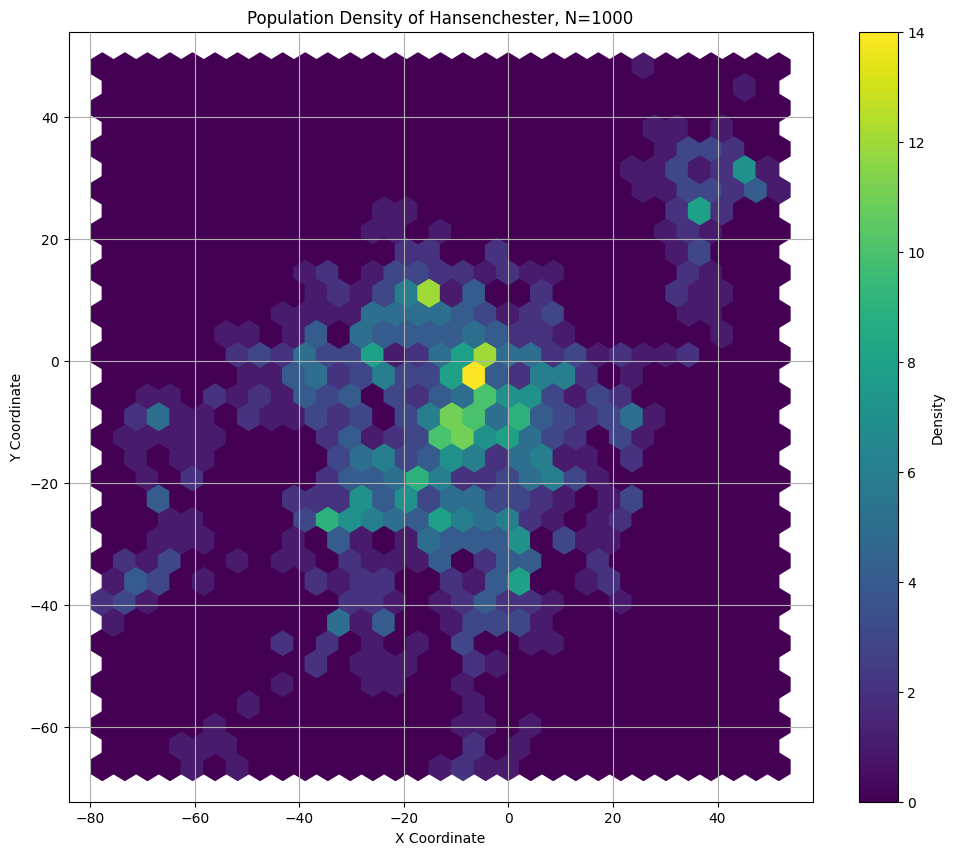

In [121]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.figure(figsize=(12, 10))
plt.hexbin(x, y, gridsize=30, cmap='viridis')
#plt.hist2d(x, y, bins=30, cmap='viridis')
plt.colorbar(label='Density')

# Add titles and labels
plt.title('Population Density of {}, N={}'.format(city_name, len(x)))
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [122]:
def evaluate_coverage_final(population_x, population_y, placement, R_dist):
    x = population_x
    y = population_y
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost
    
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage
    

In [123]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

In [124]:
# Problem Parameters
population_x = x # x coordinates of the population
population_y = y # y coordinates of the population
R_antennas = 25  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required
# Grid Parameters
spacing = 2*R_antennas  # Spacing between antennas
offset = (population_x.min(), population_y.min())  # Offset for the grid
side_lengths = (int(np.ceil((population_x.max() - population_x.min())/spacing)), int(np.ceil((population_y.max() - population_y.min())/spacing)))  # Number of antennas in each direction
grid_points = generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)  # Generate the grid points
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)
# Noise confihuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [194]:
import numpy as np
from scipy.spatial import distance

def generate_high_precision_grid(population_x, population_y, spacing, offset):
    """Generate a high-precision triangular grid with a specified spacing."""
    # Define grid boundaries
    side_lengths = (
        int(np.ceil((population_x.max() - population_x.min()) / spacing)),
        int(np.ceil((population_y.max() - population_y.min()) / spacing))
    )
    return generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)

def adaptive_selection(grid_points, population_x, population_y, R_antennas, max_grid_points):
    """Select optimal grid points based on coverage and minimal interference."""
    # Prepare population coordinates
    population_coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])

    # Calculate initial coverage for each grid point
    coverages = []
    for point in grid_points:
        dists = distance.cdist([point], population_coords, 'euclidean')
        coverage = np.sum(dists <= R_antennas)
        coverages.append(coverage)
    
    # Sort grid points based on initial coverage
    sorted_points = [pt for _, pt in sorted(zip(coverages, grid_points), reverse=True)]
    sorted_coverages = sorted(coverages, reverse=True)

    # Select grid points iteratively based on coverage and interference
    selected_points = []
    selected_coverages = []
    interference_threshold = 1.5 * R_antennas  # Define minimum distance to reduce interference

    while len(selected_points) < max_grid_points and sorted_points:
        # Choose the point with the best coverage from remaining points
        best_point = sorted_points.pop(0)
        best_coverage = sorted_coverages.pop(0)

        # Calculate interference with selected points
        if selected_points:
            dists_to_selected = distance.cdist([best_point], selected_points, 'euclidean')
            min_dist_to_selected = np.min(dists_to_selected)

            # Skip this point if it interferes too much with any selected point
            if min_dist_to_selected < interference_threshold:
                continue

        # Select this point and record its coverage
        selected_points.append(best_point)
        selected_coverages.append(best_coverage)

    return selected_points, selected_coverages

In [195]:
# Define parameters
spacing = R_antennas / 3  # Use a small spacing for high precision
high_precision_grid = generate_high_precision_grid(population_x, population_y, spacing, offset)

max_grid_points = 10

# Select optimal grid points based on density and minimal interference
grid_points, coverages = adaptive_selection(
    high_precision_grid, population_x, population_y, R_antennas, max_grid_points
)

# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

In [220]:
device_used = AnalogDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)*2
val = np.min(pdist(coords))
factor = 5/val
coords = coords*factor # Bormalize to 5 b.c. minimum distance on real NAQC is around 4um
# interaction coefficients U_ij
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
# set Rabi frequency and detunind 
omega_max = np.median(Q[Q>0].flatten()) # hyperparameter
omega_max = device_used.rabi_from_blockade(25*factor)
delta_0 = -3*omega_max
delta_f = -delta_0
print('Omega_max:', omega_max)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)

Omega_max: 45047.35226083553
Delta_0: -135142.05678250658
Delta_f: 135142.05678250658


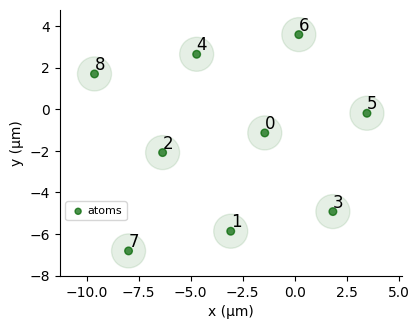

In [221]:
# create a register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

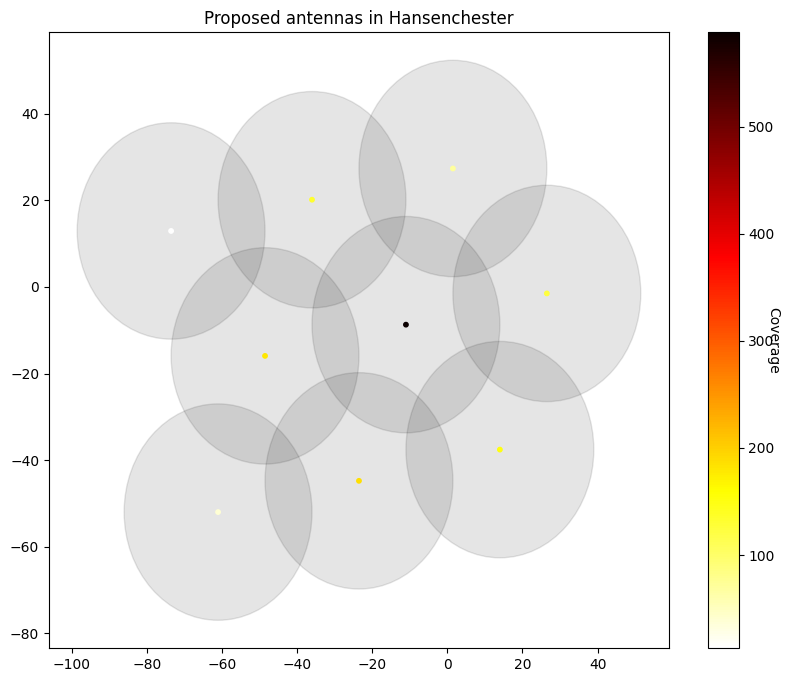

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(grid_points)[:,0], np.array(grid_points)[:,1]):
    circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
    ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

In [162]:
# time required to do a pi-pulse
t_pi = np.pi / omega_max
# number of segment for the detuning
detunings_number = 3
# number of time intervals for the detuning
time_interval_number = 2*detunings_number - 3
# effective depth for the duration of the pulse
depth = 4
sweep_time = depth * t_pi * 1e3 # duration for a pi-pulse in ns
print(f'Sweep Time = {sweep_time} ns for an effective depth of {depth} and a pi-pulse time of {t_pi} ns')

Sweep Time = 15758.99682944354 ns for an effective depth of 4 and a pi-pulse time of 3.939749207360885 ns


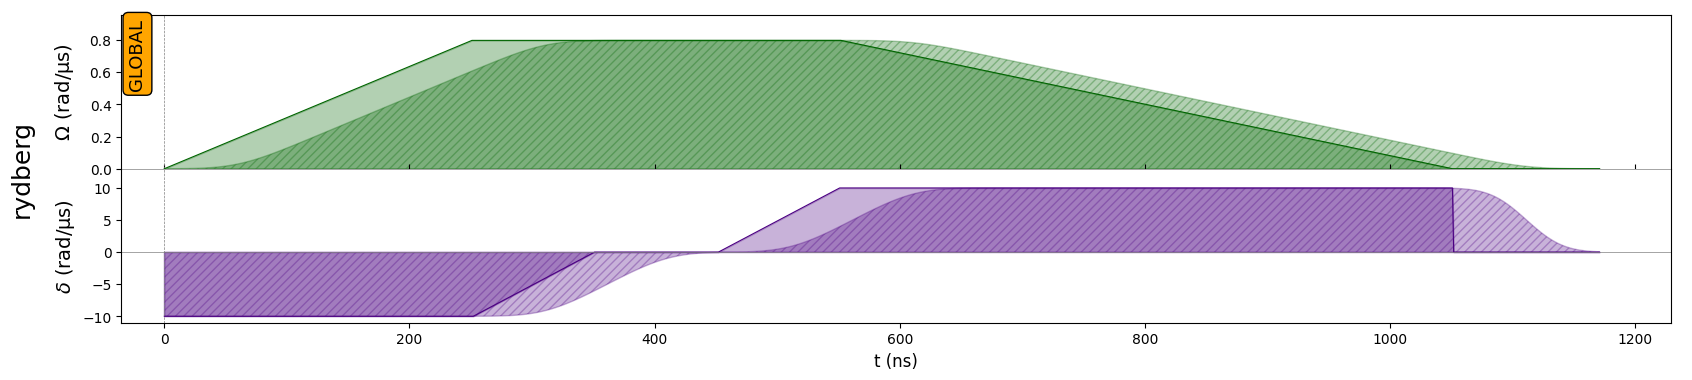

In [163]:
# parametrized sequence
parametrized_sequence = Sequence(reg, AnalogDevice)
parametrized_sequence.declare_channel("rydberg", "rydberg_global")
# Maximum Rabi Frequency
Omega_max = parametrized_sequence.declare_variable("Omega_max", size=1, dtype=float)
# time to ramp to Maximum Rabi Frequency and time to ramp to 0
t_omega = parametrized_sequence.declare_variable("t_omega", size=2, dtype=int)
# detunings values
detuning_values = parametrized_sequence.declare_variable("detuning_values", size=detunings_number, dtype=float)
# detuning times intervals
detuning_times = parametrized_sequence.declare_variable("detuning_times", size=time_interval_number, dtype=int)


# Create Pulse
list_pulses = []
# 1. rise to omega_max with 0 detuning
rabi_t_rise, rabi_t_fall = t_omega
list_pulses.append(Pulse.ConstantDetuning(
    amplitude=RampWaveform(rabi_t_rise, 0, Omega_max), 
    detuning=detuning_values[0], 
    phase=0)
    )
# 2. Rampwaveforms from \Delta_{min} to \Delta_{max} with constant Omega_max
counter = 0
for i in range(time_interval_number):
    if i % 2 ==0:
        list_pulses.append(Pulse.ConstantAmplitude(
            amplitude=Omega_max, 
            detuning=RampWaveform(detuning_times[i], detuning_values[counter], detuning_values[counter+1]),
            phase=0
            ))
        counter += 1
    else:
        list_pulses.append(Pulse.ConstantAmplitude(
            amplitude=Omega_max, 
            detuning=ConstantWaveform(detuning_times[i], detuning_values[counter]),
            phase=0
            ))
# 3. fall to 0 with \Delta_f detuning
list_pulses.append(Pulse.ConstantDetuning(
    amplitude=RampWaveform(rabi_t_fall, Omega_max, 0), 
    detuning=detuning_values[-1], 
    phase=0)
    )

# add pulses to the sequence
for i in range(len(list_pulses)):
    parametrized_sequence.add(list_pulses[i], "rydberg")

# build the sequence
sequence = parametrized_sequence.build(
    Omega_max=[omega_max],
    t_omega=[252, 500],
    detuning_times = np.array([100]*time_interval_number), 
    detuning_values = np.linspace(-10, 10, detunings_number)
)
sequence.draw()


In [164]:
simulator = QutipEmulator.from_sequence(
    sequence, 
    sampling_rate=1,
    with_modulation = False,
    config=noise_config["noiseless"],
)
simulator.show_config()
results = simulator.run(progress_bar=True)
count_dict = results.sample_final_state(N_samples=1000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.1%. Run time:   0.28s. Est. time left: 00:00:00:02
20.0%. Run time:   0.49s. Est. time left: 00:00:00:01
30.0%. Run time:   0.73s. Est. time left: 00:00:00:01
40.1%. Run time:   0.95s. Est. time left: 00:00:00:01
50.0%. Run time:   1.21s. Est. time left: 00:00:00:01
60.0%. Run time:   1.92s. Est. time left: 00:00:00:01
70.1%. Run time:   2.49s. Est. time left: 00:00:00:01
80.1%. Run time:   2.74s. Est. time left: 00:00:00:00
90.0%. Run time:   3.00s. Est. time left: 00:00:00:00
Total run time:   3.30s


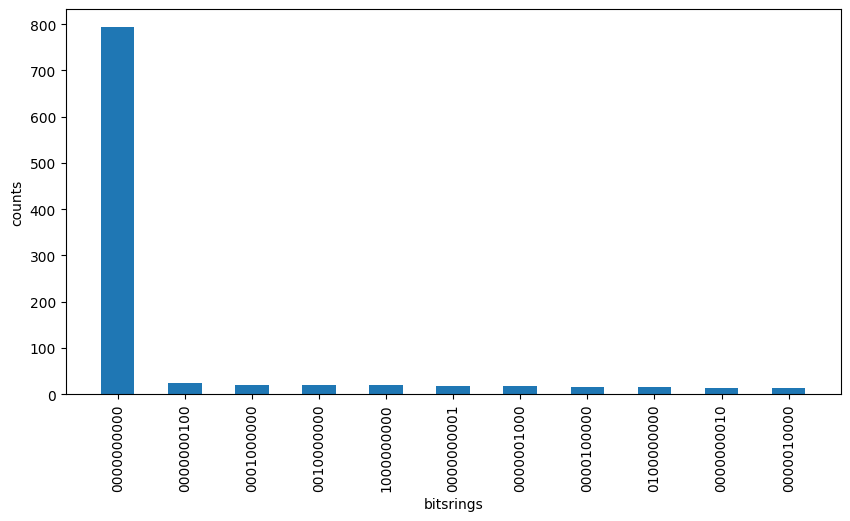

In [165]:
most_frequent = {k:v for k,v in count_dict.items() if v>10}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

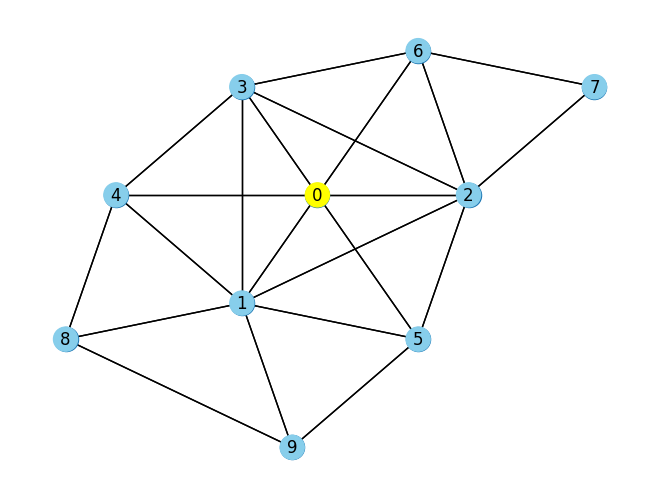

In [167]:
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)

# Sort the bitstrings in descending order
solution = sorted(most_frequent, reverse=True)

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Convert the bitstrings to lists of node indices and select the top 5
solution_indices = [convert_to_indices(res) for res in solution]
top_5 = solution_indices[:5]

# Calculate the total weight (sum of node indices) for each set in the top 5
val_list = [sum(node_set) for node_set in top_5]

# Find the index of the set with the maximum total weight
ind_max = np.argmax(val_list)

# Draw the graph with colored nodes
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

color = []
for i in solution[2]:
    if i == "1":
        color.append('yellow')
    else:
        color.append('skyblue')

nx.draw(graph, pos=grid_points, node_color=color)

In [168]:
def create_pulse(Omega_max, t_omega, detuning_values, detuning_times):
    # Create Pulse
    list_pulses = []
    # 1. rise to omega_max with 0 detuning
    rabi_t_rise, rabi_t_fall = t_omega
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_rise, 0, Omega_max), 
        detuning=detuning_values[0], 
        phase=0)
        )
    # 2. Rampwaveforms from \Delta_{min} to \Delta_{max} with constant Omega_max
    counter = 0
    for i in range(time_interval_number):
        if i % 2 ==0:
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=RampWaveform(detuning_times[i], detuning_values[counter], detuning_values[counter+1]),
                phase=0
                ))
            counter += 1
        else:
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=ConstantWaveform(detuning_times[i], detuning_values[counter]),
                phase=0
                ))
    # 3. fall to 0 with \Delta_f detuning
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_fall, Omega_max, 0), 
        detuning=detuning_values[-1], 
        phase=0)
        )
    return list_pulses
   

In [169]:
def create_sequence(register, device_used, detunings_number, time_interval_number):
    # parametrized sequence
    parametrized_sequence = Sequence(register, device_used)
    parametrized_sequence.declare_channel("rydberg", "rydberg_global")
    # Maximum Rabi Frequency
    Omega_max = parametrized_sequence.declare_variable("Omega_max", size=1, dtype=float)
    # time to ramp to Maximum Rabi Frequency and time to ramp to 0
    t_omega = parametrized_sequence.declare_variable("t_omega", size=2, dtype=int)
    # detunings values
    detuning_values = parametrized_sequence.declare_variable("detuning_values", size=detunings_number, dtype=float)
    # detuning times intervals
    detuning_times = parametrized_sequence.declare_variable("detuning_times", size=time_interval_number, dtype=int)

    # Create Pulse
    list_pulses = create_pulse(Omega_max, t_omega, detuning_values, detuning_times)

    # create sequence
    for i in range(len(list_pulses)):
        parametrized_sequence.add(list_pulses[i], "rydberg")
    return parametrized_sequence


In [170]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Function to returns the size of the MIS
def mis_size(graph, bitstring):
    # Convert bitstring to list of node indices in the independent set
    node_set = convert_to_indices(bitstring)
    
    # Check if the node set is an independent set
    for node in node_set:
        for neighbor in graph.neighbors(node):
            if neighbor in node_set:
                return 0  # Return penalty if not an independent set
    
    # Return the size of the independent set if it passes the check
    return len(node_set)

# Function to calculate the weighted mean size of the MIS
def mean_mis_size(graph, solution_dict):
    total_weighted_size = 0
    total_counts = 0
    list_sizes = []

    for bitstring, count in solution_dict.items():
        list_sizes.append(mis_size(graph, bitstring))  # Get the size of the independent set or penalty
    
    max_size = max(list_sizes)
    updated_list_sizes = [size if size == max_size else 0 for size in list_sizes]  # Replace penalties with max size

    for size, count in zip(updated_list_sizes, solution_dict.values()):
        total_weighted_size += size * count
        total_counts += count

    mean_size = total_weighted_size / total_counts

    return mean_size

In [171]:
def quantum_loop(param, device_used, graph, reg, detunings_number):
    print(param)
    # retrieve the parameters
    Omega_max_param = param[0]
    t_omega_param = param[1:3]
    detuning_values_param = param[3:3+detunings_number]
    detuning_times_param = param[3+detunings_number:]
    
    # create the sequence
    parametrized_sequence = create_sequence(reg, device_used, len(detuning_values_param), len(detuning_times_param))
    # build the sequence
    sequence = None
    try:
        sequence = parametrized_sequence.build(
            Omega_max=Omega_max_param,
            t_omega=t_omega_param,
            detuning_times = detuning_times_param, 
            detuning_values = detuning_values_param,
        )
    except:
        return 1000

    # simulation with Qutip emulator
    simulator = QutipEmulator.from_sequence(
        sequence, 
        sampling_rate=1,
        with_modulation = False,
        config=noise_config["noiseless"],
    )
    #simulator.show_config()
    results = simulator.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=1000)
    # create an ordered dictionnary of the results
    most_frequent = {k:v for k,v in count_dict.items() if v>10}
    results_dictionnary = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
    # calculate the mean size of the MIS
    mean_size = mean_mis_size(graph, results_dictionnary)
    print(f'\n ---> Mean size  = {-mean_size}')
    return -mean_size


In [172]:
def optimization_loop(device_used, graph, detunings_number, initial_guess, bounds, constraints, maxiter):
    res = minimize(
        quantum_loop,
        x0=initial_guess,
        args=(device_used, graph, reg, detunings_number),
        bounds=bounds,
        method='Nelder-Mead',  
        options={"return_all": True, "maxfev": maxiter, "adaptive": True},
    )
    return res

In [173]:
# Initial guess for the parameters 
init_omega = omega_max
init_t_omega = np.array([250, 500])
init_detuning_values = np.linspace(-10, 10, detunings_number)
init_detuning_times = np.array([100]*time_interval_number)
# Flatten and concatenate all parameters into a one-dimensional array
initial_guess = [init_omega] + init_t_omega.tolist() + init_detuning_values.tolist() + init_detuning_times.tolist()
# Maximum number of iterations
maxiter = 100
# Bounds for each parameter for the analog device (see: device_used.print_specs())
max_time_omega = (int)(4000/6)
max_time_detuning = (int)((4000-2*max_time_omega) / (time_interval_number))
print(2*max_time_omega + max_time_detuning*time_interval_number)
print(f'Max time for omega = {max_time_omega} and max time for detuning = {max_time_detuning}')
bounds = [(4, 12)]           # Bounds for Omega_max_param
bounds += [(20, max_time_omega)]*2        # Bounds for t_omega_param (since t_omega + sum(detuning_times) <= 4000)
bounds += [(-100, 100)] * detunings_number  # Bounds for each element in detuning_values_param
bounds += [(20, max_time_detuning)] * time_interval_number    # Bounds for each element in detuning_times_param

# Define the constraint for the sum of t_omega_param and detuning_times_param
def time_constraint(param):
    t_omega_param = param[1:3]
    detuning_times_param = param[3+5:]
    return 3000 - (np.sum(t_omega_param) + np.sum(detuning_times_param))

# Set up the constraint dictionary
constraints = {'type': 'ineq', 'fun': time_constraint}

3999
Max time for omega = 666 and max time for detuning = 889


In [174]:
res = optimization_loop(device_used, graph, detunings_number, initial_guess, bounds, constraints, 100)

/var/folders/2p/l5x_c52n7g7c1nx8x8v82j7c0000gn/T/ipykernel_21096/2833583308.py:2: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 250 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  self._add(pulse, channel, protocol)


[  4. 250. 500. -10.   0.  10. 100. 100. 100.]

 ---> Mean size  = -0.19937694704049844
[  4.2 250.  500.  -10.    0.   10.  100.  100.  100. ]

 ---> Mean size  = -0.30141287284144425
[  4.  262.5 500.  -10.    0.   10.  100.  100.  100. ]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 262 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 264 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.17792421746293247
[  4. 250. 525. -10.   0.  10. 100. 100. 100.]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 525 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 528 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.25848142164781907
[  4.  250.  500.  -10.5   0.   10.  100.  100.  100. ]

 ---> Mean size  = -0.1833616298811545
[ 4.0e+00  2.5e+02  5.0e+02 -1.0e+01  2.5e-04  1.0e+01  1.0e+02  1.0e+02
  1.0e+02]

 ---> Mean size  = -0.21746293245469522
[  4.  250.  500.  -10.    0.   10.5 100.  100.  100. ]

 ---> Mean size  = -0.1342281879194631
[  4. 250. 500. -10.   0.  10. 105. 100. 100.]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 105 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 108 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.21283255086071987
[  4. 250. 500. -10.   0.  10. 100. 105. 100.]

 ---> Mean size  = -0.16231884057971013
[  4. 250. 500. -10.   0.  10. 100. 100. 105.]

 ---> Mean size  = -0.17964071856287425
[ 4.04444444e+00  2.52777778e+02  5.05555556e+02 -1.01111111e+01
  5.55555556e-05  9.50000000e+00  1.01111111e+02  1.01111111e+02
  1.01111111e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 101 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 104 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 505 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 508 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2376237623762376
[ 4.05432099e+00  2.53395062e+02  5.06790123e+02 -1.01358025e+01
  6.79012346e-05  9.88888889e+00  1.01358025e+02  9.52469136e+01
  1.01358025e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 253 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 256 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 95 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 96 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 506 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 508 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2015748031496063
[ 4.06639232e+00  2.38871742e+02  5.08299040e+02 -1.01659808e+01
  8.29903978e-05  9.86419753e+00  1.01659808e+02  9.91906722e+01
  1.01659808e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 238 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 240 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 99 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 100 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.20298507462686566
[ 4.08114617e+00  2.48898796e+02  5.10143271e+02 -1.02028654e+01
  1.01432708e-04  9.83401920e+00  1.02028654e+02  9.90108215e+01
  9.59175431e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 102 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 104 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 510 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 512 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.22841225626740946
[ 4.09917865e+00  2.48654084e+02  5.12397331e+02 -9.63683551e+00
  1.23973310e-04  9.79713458e+00  1.02479466e+02  9.87910041e+01
  1.00010330e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 98 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 100 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.15954415954415954
[ 4.01515229e+00  2.49794374e+02  5.01894037e+02 -1.03681276e+01
  1.89403669e-05  9.96900667e+00  1.00378807e+02  9.98152923e+01
  1.00001578e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 249 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 501 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 504 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.19411764705882353
[ 4.08402635e+00  2.48859710e+02  5.10503294e+02 -9.76870786e+00
  1.05032943e-04  9.82812791e+00  1.02100659e+02  9.89757118e+01
  1.00008752e+02]

 ---> Mean size  = -0.2276923076923077
[ 4.11785117e+00  2.48400686e+02  5.14731396e+02 -1.00854373e+01
  1.47313964e-04  9.75894079e+00  1.02946279e+02  9.85633845e+01
  1.00012275e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 514 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 516 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.3067484662576687
[ 4.13094575e+00  2.48222985e+02  5.16368218e+02 -1.00949303e+01
  1.63682183e-04  9.73215643e+00  1.03273644e+02  9.84037605e+01
  1.00013639e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 103 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 104 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.25768667642752563
[ 4.07764800e+00  2.43895763e+02  5.09706000e+02 -9.93844252e+00
  9.70600031e-05  9.84117454e+00  1.01941200e+02  1.04053464e+02
  9.83551952e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 243 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 244 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 509 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 512 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.30236220472440944
[ 4.06807794e+00  2.59535532e+02  5.08509742e+02 -9.85770013e+00
  8.50974189e-05  9.86074968e+00  1.01701948e+02  1.01190326e+02
  9.73190536e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 259 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 260 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 97 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 100 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2184873949579832
[ 4.14959868e+00  2.50526281e+02  5.18699835e+02 -9.99205873e+00
  1.86998354e-04  9.69400269e+00  9.76288560e+01  1.00645515e+02
  9.83830957e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 518 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 520 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.20757363253856942
[ 4.02285535e+00  2.50080404e+02  5.02856919e+02 -9.99878675e+00
  2.85691930e-05  9.95325041e+00  1.03873853e+02  1.00098620e+02
  9.97529729e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 502 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 504 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.20574886535552195
[ 4.08211502e+00  2.44396310e+02  5.10264378e+02 -9.95477527e+00
  1.02643777e-04  9.83203746e+00  1.02052876e+02  1.03443456e+02
  9.85393152e+01]

 ---> Mean size  = -0.2396576319543509
[ 4.19087235e+00  2.49822298e+02  5.01636822e+02 -1.00094930e+01
  1.63682183e-05  9.97321564e+00  1.00327364e+02  9.98403761e+01
  1.00001364e+02]

 ---> Mean size  = -0.26993865030674846
[ 4.01309457e+00  2.49822298e+02  5.23859044e+02 -1.00094930e+01
  1.63682183e-05  9.97321564e+00  1.00327364e+02  9.98403761e+01
  1.00001364e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 523 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 524 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.1875945537065053
[ 4.05260075e+00  2.52291434e+02  5.06575093e+02 -1.01082585e+01
  6.57509343e-05  9.52877120e+00  1.01315019e+02  1.00828030e+02
  1.00989018e+02]

 ---> Mean size  = -0.20833333333333334
[ 4.08522450e+00  2.48843450e+02  5.10653063e+02 -1.01898178e+01
  1.06530626e-04  9.82567716e+00  1.02130613e+02  9.89611063e+01
  9.63725133e+01]

 ---> Mean size  = -0.21925925925925926
[ 4.08778467e+00  2.48808707e+02  5.10973083e+02 -9.80390002e+00
  1.09730835e-04  9.82044045e+00  1.02194617e+02  9.89298976e+01
  1.00009144e+02]

 ---> Mean size  = -0.25396825396825395
[ 4.07360829e+00  2.58298327e+02  5.09201037e+02 -9.88300426e+00
  9.20103684e-05  9.84943758e+00  1.01840207e+02  1.00898444e+02
  9.76183004e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 258 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 260 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.26046511627906976
[ 4.01309457e+00  2.49822298e+02  5.01636822e+02 -1.00094930e+01
  2.38590440e-04  9.97321564e+00  1.00327364e+02  9.98403761e+01
  1.00001364e+02]

 ---> Mean size  = -0.22653721682847897
[ 4.01309457e+00  2.49822298e+02  5.01636822e+02 -1.00094930e+01
  1.63682183e-05  9.97321564e+00  1.04771809e+02  9.98403761e+01
  1.00001364e+02]

 ---> Mean size  = -0.17595307917888564
[ 4.14607118e+00  2.50290104e+02  5.18258898e+02 -1.00024341e+01
  1.82588978e-04  9.70121804e+00  9.82196808e+01  1.00414168e+02
  9.85641156e+01]

 ---> Mean size  = -0.2036775106082037
[ 4.17562154e+00  2.50394061e+02  4.94792199e+02 -1.00008655e+01
  2.19526924e-04  9.64077412e+00  1.02195751e+02  1.00541677e+02
  9.82447271e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 494 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 496 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.26285714285714284
[ 4.04921168e+00  2.49949357e+02  4.95177523e+02 -1.00075758e+01
  6.15145973e-05  9.89933975e+00  1.05187006e+02  9.99962207e+01
  9.96110002e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 495 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 496 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.21652421652421652
[ 4.14192899e+00  2.47427565e+02  5.04328534e+02 -9.87937753e+00
  1.77411232e-04  1.01541352e+01  1.02952110e+02  9.93975113e+01
  9.68798713e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 247 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 248 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.16589861751152074
[ 4.06624812e+00  2.51548343e+02  5.06231869e+02 -1.00732905e+01
  8.28101465e-05  9.62431291e+00  1.01565130e+02  1.00609479e+02
  1.00361232e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 251 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 252 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.20454545454545456
[ 4.18275889e+00  2.49664342e+02  5.03091775e+02 -1.00179313e+01
  3.09177456e-05  9.94940733e+00  1.00618355e+02  9.96984881e+01
  1.00002576e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 503 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 504 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2634730538922156
[ 4.16920261e+00  2.50172575e+02  4.97007665e+02 -1.00102623e+01
  2.11503262e-04  9.65390375e+00  1.02279143e+02  1.00321867e+02
  9.84411213e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 497 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 500 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.24725274725274726
[ 4.07852417e+00  2.57198589e+02  5.09815521e+02 -9.90549681e+00
  9.81552124e-05  9.83938238e+00  1.01963104e+02  1.00638993e+02
  9.78842976e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 257 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 260 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.20437956204379562
[ 4.09112539e+00  2.48763372e+02  5.11390674e+02 -9.83518193e+00
  1.13906738e-04  9.81360716e+00  1.02278135e+02  9.88891740e+01
  1.00009492e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 511 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 512 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2543352601156069
[ 4.08608570e+00  2.44841241e+02  5.10760713e+02 -9.96929327e+00
  1.07607131e-04  9.82391560e+00  1.02152143e+02  1.02901225e+02
  9.87029775e+01]

 ---> Mean size  = -0.21480406386066764
[ 4.02473420e+00  2.49664342e+02  5.03091775e+02 -1.00179313e+01
  2.28448610e-04  9.94940733e+00  1.00618355e+02  9.96984881e+01
  1.00002576e+02]

 ---> Mean size  = -0.2078740157480315
[ 4.08884969e+00  2.48794254e+02  5.11106211e+02 -1.01782200e+01
  1.11062108e-04  9.81826201e+00  1.02221242e+02  9.89169150e+01
  9.67769313e+01]

 ---> Mean size  = -0.1781609195402299
[ 4.05683829e+00  2.49777282e+02  4.97350175e+02 -1.00162271e+01
  7.10478603e-05  9.88373986e+00  1.04938036e+02  9.98370166e+01
  9.96555863e+01]

 ---> Mean size  = -0.24082232011747431
[ 4.05985079e+00  2.51859129e+02  5.07481349e+02 -1.01057228e+01
  7.48134932e-05  9.55434560e+00  1.01496270e+02  1.00576403e+02
  1.00880491e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 507 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 508 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.21965317919075145
[ 4.10381058e+00  2.51281647e+02  5.01054021e+02 -9.81366533e+00
  1.29763229e-04  9.78766017e+00  1.02065385e+02  1.01333094e+02
  1.02243378e+02]

 ---> Mean size  = -0.24477611940298508
[ 4.11975530e+00  2.41562436e+02  5.00397711e+02 -1.00659815e+01
  1.49694128e-04  9.75504597e+00  1.02346251e+02  9.97652605e+01
  1.02104697e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 241 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 244 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.22189781021897811
[ 4.19466108e+00  2.47296261e+02  5.06522776e+02 -9.96422490e+00
  1.89973501e-06  9.60182961e+00  1.04074978e+02  1.00720604e+02
  1.00453556e+02]

 ---> Mean size  = -0.22727272727272727
[ 4.15743743e+00  2.52664921e+02  4.97912074e+02 -1.00117366e+01
  9.92506816e-05  9.67796889e+00  1.02968487e+02  9.70332836e+01
  1.02142172e+02]

 ---> Mean size  = -0.2764456981664316
[ 4.20535826e+00  2.45826098e+02  4.99064932e+02 -9.85442128e+00
  1.37474806e-04  9.97501074e+00  1.03951519e+02  9.85707461e+01
  1.00245032e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 245 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 248 ns.
  self._add(pulse, channel, protocol)
/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 499 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 500 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2485207100591716
[ 4.16447663e+00  2.57070271e+02  5.05852398e+02 -9.84714914e+00
  5.98787653e-05  9.82319143e+00  1.03458263e+02  9.91164410e+01
  9.86075676e+01]

 ---> Mean size  = -0.2517482517482518
[ 4.08286320e+00  2.53508449e+02  4.99578359e+02 -9.92288893e+00
  2.20557388e-04  1.00255993e+01  1.01592489e+02  9.78046174e+01
  9.98484888e+01]

 ---> Mean size  = -0.17391304347826086
[ 4.17758085e+00  2.48245345e+02  5.05461824e+02 -9.95790968e+00
  3.53057653e-05  9.66657221e+00  1.03695709e+02  1.00275106e+02
  1.00361115e+02]

 ---> Mean size  = -0.27167630057803466
[ 4.24751767e+00  2.50686997e+02  5.10553549e+02 -9.85792734e+00
  1.43466574e-04  9.69542957e+00  1.00453358e+02  9.87855574e+01
  1.00803242e+02]

 ---> Mean size  = -0.2096551724137931
[ 4.08596986e+00  2.49916266e+02  4.99367358e+02 -9.99204239e+00
  8.21118306e-05  9.85497024e+00  1.04252877e+02  9.96763770e+01
  9.98309227e+01]

 ---> Mean size  = -0.29283489096573206
[ 4.19658077e+00 

/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 255 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 256 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.25748502994011974
[ 4.08333534e+00  2.43859498e+02  5.06986616e+02 -1.00764096e+01
  7.61553315e-05  9.76149323e+00  1.02000443e+02  9.92026262e+01
  1.02919558e+02]

 ---> Mean size  = -0.2422360248447205
[ 4.15208004e+00  2.55051958e+02  5.06025681e+02 -9.88217504e+00
  6.23654629e-05  9.81376532e+00  1.03235541e+02  9.91296082e+01
  9.92663439e+01]

 ---> Mean size  = -0.28059701492537314
[ 4.17023206e+00  2.53563860e+02  5.00256119e+02 -1.00988197e+01
  1.06737421e-05  9.77111265e+00  1.03393328e+02  9.94833231e+01
  1.01352490e+02]

 ---> Mean size  = -0.22028985507246376
[ 4.10321113e+00  2.49496780e+02  5.09689561e+02 -9.87545993e+00
  9.81350303e-05  9.80711494e+00  1.02448512e+02  9.89799467e+01
  1.00214672e+02]

 ---> Mean size  = -0.2441860465116279
[ 4.11786591e+00  2.48680011e+02  5.13303709e+02 -1.00601032e+01
  1.44420035e-04  9.76245108e+00  1.02878053e+02  9.87962387e+01
  1.00182700e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 513 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 516 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2658959537572254
[ 4.08952697e+00  2.50027193e+02  4.99646785e+02 -9.97708551e+00
  8.64625825e-05  9.84781059e+00  1.04039474e+02  9.97855655e+01
  1.00021497e+02]

 ---> Mean size  = -0.23420647149460708
[ 4.11960423e+00  2.50237786e+02  5.10524225e+02 -9.86822009e+00
 -1.10858663e-05  9.95057983e+00  1.03468171e+02  9.83021041e+01
  1.02102100e+02]

 ---> Mean size  = -0.32989690721649484
[ 4.14829157e+00  2.54592253e+02  5.05565296e+02 -9.87942565e+00
  6.89102557e-05  9.81118400e+00  1.03135175e+02  9.92995487e+01
  9.95196497e+01]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 254 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 256 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.23563218390804597
[ 4.15305369e+00  2.52470442e+02  4.98353200e+02 -9.99459148e+00
  1.01697117e-04  9.69047607e+00  1.02897793e+02  9.74361491e+01
  1.02075941e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 498 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 500 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2808022922636103
[ 4.17095895e+00  2.48541930e+02  5.05064089e+02 -9.94674533e+00
  4.48571911e-05  9.68034568e+00  1.03544213e+02  1.00317769e+02
  1.00492780e+02]

 ---> Mean size  = -0.341534008683068
[ 4.17556166e+00  2.49803260e+02  5.02957378e+02 -1.00000979e+01
  4.09567292e-05  9.93175467e+00  1.00808787e+02  9.98052197e+01
  1.00174079e+02]

 ---> Mean size  = -0.2282453637660485
[ 4.07056682e+00  2.54956053e+02  5.11172490e+02 -1.00097376e+01
  2.21038767e-05  9.66427730e+00  1.01914186e+02  9.97473938e+01
  1.00879181e+02]

 ---> Mean size  = -0.27034482758620687
[ 4.09410966e+00  2.49002398e+02  5.10334178e+02 -9.83765400e+00
  1.14724722e-04  9.81104341e+00  1.02284147e+02  9.90858294e+01
  1.00180225e+02]

 ---> Mean size  = -0.24169184290030213
[ 4.06487426e+00  2.52290668e+02  5.09452884e+02 -9.87345622e+00
  1.13122940e-04  9.62573453e+00  1.05078648e+02  9.87347071e+01
  1.01381515e+02]

 ---> Mean size  = -0.36199095022624433
[ 4.05257566e+00  

/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 515 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 516 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.2282453637660485
[ 4.11465829e+00  2.53081827e+02  5.06310873e+02 -9.99676521e+00
  3.79953856e-05  9.72845884e+00  1.04433090e+02  1.00086279e+02
  1.01070013e+02]

 ---> Mean size  = -0.23008849557522124
[ 4.12492525e+00  2.52793817e+02  5.17049560e+02 -9.87975810e+00
  5.16885191e-05  9.67473765e+00  1.02934612e+02  9.95570634e+01
  1.01410527e+02]


/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/pulser/sequence/sequence.py:1282: UserWarning: A duration of 517 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 520 ns.
  self._add(pulse, channel, protocol)



 ---> Mean size  = -0.20634920634920634
[ 4.09261433e+00  2.50662946e+02  5.03228648e+02 -9.95246082e+00
  8.36595725e-05  9.80046359e+00  1.03968499e+02  9.96517320e+01
  1.00361737e+02]

 ---> Mean size  = -0.19411764705882353
[ 4.14869426e+00  2.49328702e+02  5.05985194e+02 -9.93136366e+00
  5.91845705e-05  9.66888408e+00  1.03866255e+02  9.99855212e+01
  1.00679304e+02]

 ---> Mean size  = -0.3045977011494253
[ 4.10674420e+00  2.49437803e+02  5.12495511e+02 -1.00209304e+01
  1.37851509e-04  9.73375748e+00  1.03339907e+02  9.87833247e+01
  1.00434303e+02]

 ---> Mean size  = -0.1839080459770115
[ 4.06937209e+00  2.54396651e+02  5.10811585e+02 -9.98113532e+00
  4.12066431e-05  9.65618807e+00  1.02578332e+02  9.95348546e+01
  1.00984609e+02]

 ---> Mean size  = -0.17287630402384502
[ 4.13078424e+00  2.54109204e+02  5.06381209e+02 -9.87817281e+00
  7.81894610e-05  9.77226250e+00  1.03543064e+02  9.91810017e+01
  9.99104116e+01]

 ---> Mean size  = -0.25554106910039115
[ 4.10683736e+00

Omega_max =  4.064874257657178
t_omega =  [252.29066759 509.45288418]
detuning_times =  [105.07864798  98.7347071  101.38151495]
detuning_values =  [-9.87345622e+00  1.13122940e-04  9.62573453e+00]


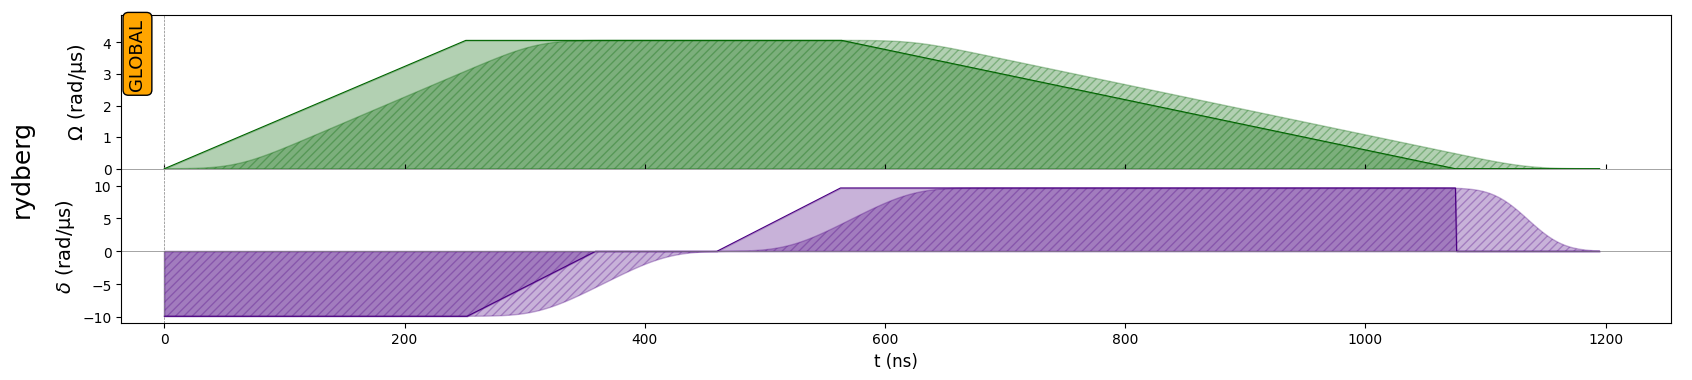

In [177]:
# retrieve the parameters
Omega_max_param = res.x[0]
t_omega_param = res.x[1:3]
detuning_values_param = res.x[3:3+detunings_number]
detuning_times_param = res.x[3+detunings_number:]

print('Omega_max = ', Omega_max_param)
print('t_omega = ', t_omega_param)
print('detuning_times = ', detuning_times_param)
print('detuning_values = ', detuning_values_param)

# create the sequence
parametrized_sequence = create_sequence(reg, device_used, len(detuning_values_param), len(detuning_times_param))
# build the sequence
sequence = parametrized_sequence.build(
    Omega_max=Omega_max_param,
    t_omega=t_omega_param,
    detuning_times = detuning_times_param, 
    detuning_values = detuning_values_param,
)
sequence.draw()

In [178]:
simulator = QutipEmulator.from_sequence(
    sequence, 
    sampling_rate=1,
    with_modulation = False,
    config=noise_config["noiseless"],
)
simulator.show_config()
results = simulator.run(progress_bar=True)
count_dict = results.sample_final_state(N_samples=1000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.36s. Est. time left: 00:00:00:03
20.1%. Run time:   0.72s. Est. time left: 00:00:00:02
30.1%. Run time:   1.04s. Est. time left: 00:00:00:02
40.0%. Run time:   1.27s. Est. time left: 00:00:00:01
50.0%. Run time:   1.61s. Est. time left: 00:00:00:01
60.1%. Run time:   1.91s. Est. time left: 00:00:00:01
70.0%. Run time:   2.22s. Est. time left: 00:00:00:00
80.0%. Run time:   2.54s. Est. time left: 00:00:00:00
90.1%. Run time:   2.83s. Est. time left: 00:00:00:00
Total run time:   3.12s


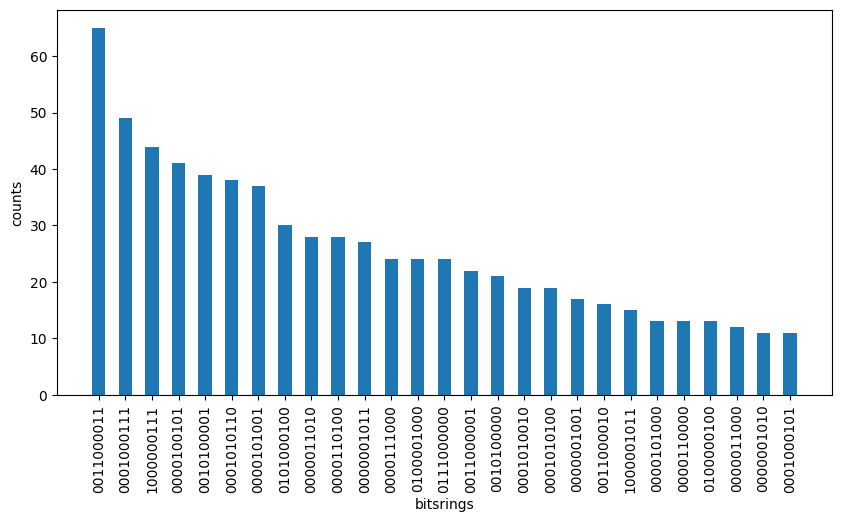

In [179]:
most_frequent = {k:v for k,v in count_dict.items() if v>10}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

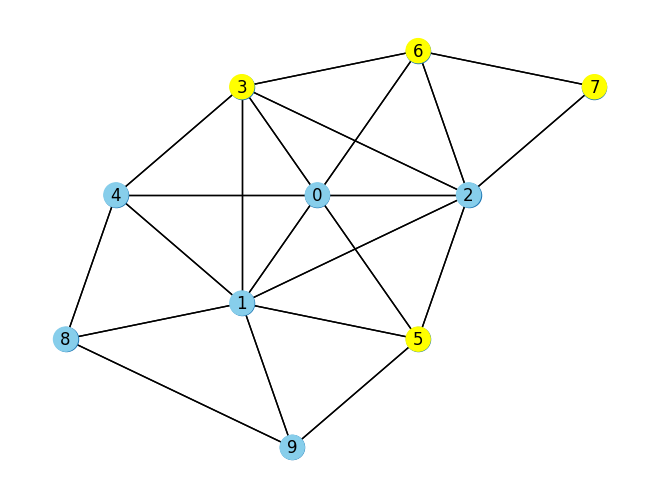

In [181]:
graph = nx.Graph()
edges = KDTree(grid_points).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)

# Sort the bitstrings in descending order
solution = sorted(most_frequent, reverse=True)

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Convert the bitstrings to lists of node indices and select the top 5
solution_indices = [convert_to_indices(res) for res in solution]
top_5 = solution_indices[:5]

# Calculate the total weight (sum of node indices) for each set in the top 5
val_list = [sum(node_set) for node_set in top_5]

# Find the index of the set with the maximum total weight
ind_max = np.argmax(val_list)

# Draw the graph with colored nodes
nx.draw(graph, pos=grid_points)
nx.draw_networkx_labels(graph, pos=grid_points)

color = []
for i in solution[0]:
    if i == "1":
        color.append('yellow')
    else:
        color.append('skyblue')

nx.draw(graph, pos=grid_points, node_color=color)